</center><img src="ML integration workflow.jpg"  width="1600" height="600"/></center>

### Import packages

In [40]:
import pandas as pd
import uuid
# for creating extent from centroid
from utils import create_extent_from_centroid, produce_geojson

# for adding model prediction results to csv file
from utils import add_yolov5_conf_scores, add_efficientnet_conf_scores

# for nearest neighbour merge
import geopandas as gpd
import numpy as np

### Params

In [2]:
csv_dir = "data/BASIC SCHOOL DATA + GPS.csv"

# params from original csv file
original_lat_col_name = "lat"
original_lon_col_name = "lon"
original_crs = "EPSG:4326"


# grid size for downloading school tiles for validation with ML models
tile_width = 256
tile_height = 256
spatial_resolution = 0.6 # in meters


# image downloading


# adding model prediction results to DataFrame
model_1_name = "efficientnet" # classification model
model_2_name = "yolov5" # object detection model

model_1_pred_folder = f"data/{model_1_name}_predictions" # data/efficientnet_preds
model_2_pred_folder = f"data/{model_2_name}_predictions" # data/yolov5_preds

model_1_conf_col = f"conf_{model_1_name}" # "conf_efficientnet"
model_2_conf_col = f"conf_{model_2_name}" # "conf_yolov5"


# for nearest neighbour merge
pred_gjson_dir = "data/sudan_predictions_centroid_validated_conf_5.geojson"
pred_data_src_crs = "EPSG:3857" # crs location points in model prediction file 
max_distance = 300 # nearest neighbour distance
drop_threshold = 0.5

In [3]:
# read csv file
df = pd.read_csv(csv_dir)

# create a new column and add row indexes from the original csv file 
df['original_index'] = df.index

## 1. Drop NAN rows

In [ ]:
"""
Assumes lat / lon columns contain NaN values
"""

In [5]:
# create a separate df for rows with missing lat/lon values
df_nan_latlon = df[df[original_lat_col_name].isna() | df[original_lon_col_name].isna()].copy()

# DataFrame without missing lat/lon values (drop nan rows for both lat / lon colulmn)
df = df[df[original_lat_col_name].notna()]
df = df[df[original_lon_col_name].notna()]

In [ ]:
"""  save the file (optional)  """

# df.to_csv("latlon_nan_rows_dropped.csv", index = False)
# df_nan_latlon.to_csv("nan_latlon_rows.csv", index = False)

## 2. Drop duplicates

In [ ]:
"""
Assumes there are duplicated lat / lon values in csv file.
Drop duplicates keep only the first row.
Cause: 
    - ground team could not locate the exact location of school but is sure there is a school nearby
    - same location point could occur multiple times with different school attributes
"""

In [6]:
# drop duplicates
df_without_duplicates = df.drop_duplicates(subset = [original_lat_col_name, original_lon_col_name],
                                           keep="first"
                                          ).copy()

print(f"After dropping duplicates: {len(df_without_duplicates)} rows")

# create a separate DataFrame with only duplicated rows
df_duplicated_rows = df[~ df.index.isin(df_without_duplicates.index) ].copy()

df = df_without_duplicates

After dropping duplicates: 12279 rows


In [ ]:
"""  Save file (Optional)  """

# # cleaned csv file (optional)
# df.to_csv("cleaned.csv", index = False)

# # a separate csv file with only dropped duplicated rows (optional)
# df_duplicated_rows.to_csv("duplicated_rows.csv", index = False)

## 3. Create extent from centroid

In [7]:
# get x, y (lon / lat) values 
lat_col_values = df[original_lat_col_name]
lon_col_values = df[original_lon_col_name]

# Calculate four corner points of the grid
top, left, bottom, right = create_extent_from_centroid(src_crs = original_crs,
                                                       x = lon_col_values,
                                                       y = lat_col_values,
                                                       grid_width = tile_width,
                                                       grid_height = tile_height,
                                                       spatial_resolution = spatial_resolution)

# add four corner grid points to DataFrame
df["top"] = top
df["left"] = left
df["bottom"] = bottom
df["right"] = right

# Add a new column: image ids for downloading and validation by ML models
df['image_id'] = list(range(1, len(df)+1))

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
"""  Save csv file (optional)  """

# df.to_csv("with_grid_extent.csv", index = False)

### Optional - generate geojson file

In [ ]:
# produce_geojson(df = df, 
#                 crs = original_crs, 
#                 columns =  ["image_id", "MOEcode", "location", "lat", "lon", "top", "left", "bottom", "right"], 
#                 save_dir = f"school_locations_with_{tile_width}_grids_1.geojson")

## 4. Data downloading

In [ ]:
"""
Done in a separate notebook.
"""

## 5. Model training & prediction

In [ ]:
"""
Model training is done separately.
Currently, we use two models:
    1. EfficientNet (classification model)
    2. YOLOv5 (object detection model)
"""

## 6. Add model prediction results to DataFrame

In [ ]:
# put NaN values in two model conf score columns
df[model_1_conf_col] = np.nan
df[model_2_conf_col] = np.nan

#####  add model probability scores to DataFrame  #####

# add model 1 (EfficientNet) probability scores to DataFrame
df = add_efficientnet_conf_scores(original_df = df,
                                  predictions_folder = model_1_pred_folder,
                                  school_class_id = 1, 
                                  school_conf_col = model_1_conf_col, 
                                  image_id_col = "image_id")

# add model 2 (YOLOv5) probability scores to DataFrame
df = add_yolov5_conf_scores(original_df = df, 
                            predictions_folder = model_2_pred_folder,
                            school_conf_col = model_2_conf_col, 
                            image_id_col = "image_id")

# replace NaNs with zeros
df[model_1_conf_col] = df[model_1_conf_col].fillna(0)
df[model_2_conf_col] = df[model_2_conf_col].fillna(0)

# reset index
df = df.reset_index(drop = True)

In [8]:
df = pd.read_csv('df.csv')

## 7. Nearest neighbour merge
Merge before dropping conf = 0 gov points so that we can keep the gov school data attributes

3 different location types:
  - 0: dropped points
  - 1: gov data
  - 2: ML prediction

In [9]:
# the two dataframes to be merged
gt_df = df
pred_df = gpd.read_file(pred_gjson_dir) # centroid data

# convert crs to 4326 if source crs is 3857
if pred_data_src_crs == "EPSG:3857":
    pred_df = pred_df.to_crs("EPSG:4326")
    
print("num gov points:", len(gt_df))
print("num pred points:", len(pred_df))

# rename gov gt and pred df columns
gt_df = gt_df.rename({'image_id': 'gt_image_id'}, 
                     axis=1)
pred_df = pred_df.rename({'image_id': 'pred_image_id'},
                         axis=1)

# add lat / lon in pred_df (geometry is centroid)
pred_df['lat_pred'] = pred_df.geometry.y
pred_df['lon_pred'] = pred_df.geometry.x

# select columns
pred_df = pred_df[ ["lat_pred", "lon_pred", "prob", "pred_image_id", "geometry"] ]

num gov points: 12279
num pred points: 16880


### 7.1. Create a GeoDataFrame for gt csv data

In [10]:
# create geometry column for gt csv file
geometry = gpd.points_from_xy(gt_df.lon, gt_df.lat, crs = original_crs) # 'EPSG:4326'

# create geo-dataframe
gt_df = gpd.GeoDataFrame(gt_df, 
                         geometry = geometry)

In [ ]:
"""  Save geojson files (Optional)  """

# gt_df.to_file("gt.geojson")
# pred_df.to_file("pred.geojson")

### 7.2. Merge - sjoin_nearest ( how = left )

In [11]:
# get nearest points to gov points from predictions df
# all points from ground truth csv file will be kept

nearest_df = gpd.sjoin_nearest(gt_df.to_crs("EPSG:3857"),
                               pred_df.to_crs("EPSG:3857"),
                               how = 'left', # keep all rows from left df (gov gt csv)
                               distance_col = 'dist',
                               max_distance = max_distance)

### 7.3. Drop duplicated ML points from nearest neighbour df

In [ ]:
"""
- one ML point can be associated with multiple gt gov points
- drop duplciated ML points
"""

In [12]:
# create a df that contains only gov points with ML points very nearby
nn_gov_points_df = nearest_df.loc[nearest_df['index_right'].notnull()]


"""  sort by distance and drop duplicates  """
# sort by distance
nn_gov_points_df = nn_gov_points_df.sort_values(by=['dist'],
                                                ascending=False)

# drop duplicates after sorting by distance
nn_gov_points_df = nn_gov_points_df.drop_duplicates(
    subset=["index_right", "lat_pred", "lon_pred", "prob", "pred_image_id"], 
    keep="first")

# keep only first nearest point in gt dataframe, 
# replace duplicated point rows with null
columns_to_nullify = [ "index_right", "lat_pred", "lon_pred", "prob", "pred_image_id", "dist" ]

# row, column indexer
nearest_df.loc[~nearest_df.index.isin(nn_gov_points_df.index), columns_to_nullify] = np.nan

# check if it actually dropped duplicates. e.g. 6632 is correct for sudan.
print("Total ML points near gov points:", len(nearest_df[nearest_df['index_right'].notna()]))

Total ML points near gov points: 4765


### Split the preds df into 2 parts
- one with points merged in gt csv file
- one with points that weren't merged in csv file

In [13]:
pred_indexes_in_nn = list(nearest_df['index_right'])

# points that are near gt_df points (i.e. merged points)
points_near_gt = pred_df[pred_df.index.isin(pred_indexes_in_nn)]

# points that are not near gt points
points_away_from_gt = pred_df[~pred_df.index.isin(pred_indexes_in_nn)].copy()

print("merged in gt df:", len(points_near_gt))
print("not merged points:", len(points_away_from_gt))

merged in gt df: 4765
not merged points: 12115


In [16]:
points_away_from_gt.head()

,lat_pred,lon_pred,prob,pred_image_id,geometry,index_right
0,12.176462,27.260175,0.501138,2816140,POINT (27.26018 12.17646),0
1,12.150006,27.333628,0.560980,2855345,POINT (27.33363 12.15001),1
2,14.498809,27.378001,0.567826,2877297,POINT (27.37800 14.49881),2
3,11.721673,27.379092,0.598463,2877826,POINT (27.37909 11.72167),3
4,13.275298,27.463983,0.507150,2922331,POINT (27.46398 13.27530),4


In [17]:
points_away_from_gt_v2 = points_away_from_gt.to_crs("EPSG:4326")

In [18]:
points_away_from_gt_v2.head()

,lat_pred,lon_pred,prob,pred_image_id,geometry,index_right
0,12.176462,27.260175,0.501138,2816140,POINT (27.26018 12.17646),0
1,12.150006,27.333628,0.560980,2855345,POINT (27.33363 12.15001),1
2,14.498809,27.378001,0.567826,2877297,POINT (27.37800 14.49881),2
3,11.721673,27.379092,0.598463,2877826,POINT (27.37909 11.72167),3
4,13.275298,27.463983,0.507150,2922331,POINT (27.46398 13.27530),4


In [15]:
nearest_df.head()

,Unnamed: 0,year(العام),state_nam,locality_nam,school_nam,MOEcode,location,lat,lon,Type,...,gt_image_id,conf_efficientnet,conf_yolov5,geometry,index_right,lat_pred,lon_pred,prob,pred_image_id,dist
0,0,2018_2019,Northern,murwi,فرح محمد بك القرانيه,11101301.0,urban,18.538573,31.840170,boys,...,1,0.000033,0.000000,POINT (3544431.556 2100685.006),9484.0,18.538836,31.841101,0.853277,5194915,108.052335
1,1,2018_2019,Northern,murwi,مصطفى مبروك بنين,11101302.0,urban,18.544802,31.843675,boys,...,2,0.999996,0.876609,POINT (3544821.738 2101416.367),NaN,NaN,NaN,NaN,NaN,NaN
2,2,2018_2019,Northern,murwi,سر الختم محمد الطيب بنين,11101303.0,rural,18.517909,31.820415,boys,...,3,0.684962,0.154784,POINT (3542232.400 2098258.877),9451.0,18.517528,31.819590,0.925019,5183719,102.191048
3,3,2018_2019,Northern,murwi,مروي شرق بنين,11101304.0,urban,18.483851,31.800364,boys,...,4,0.000099,0.000000,POINT (3540000.369 2094261.019),9439.0,18.484810,31.801202,0.932861,5175326,146.156841
4,4,2018_2019,Northern,murwi,الشهيد جكنون الاساسيه بنين,11101305.0,urban,18.560670,31.855010,boys,...,5,0.528040,0.885101,POINT (3546083.507 2103279.562),NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
"""  Save the splitted dataframess (optional)  """
# ML points near gov points and points away from gov points
# points_near_gt.to_file('points_near_gt_df_dist_300.geojson')
# points_away_from_gt.to_file('points_away_gt_df_dist_300.geojson')

### Append the ML dataframe to gov dataframe
- appends ML points that have not been merged to gov dataframe
- these are the new discovery points by the ML model

In [20]:
# add index column
points_away_from_gt_v2 = points_away_from_gt.to_crs("EPSG:4326")
nearest_df_v2 = nearest_df.to_crs("EPSG:4326")

points_away_from_gt_v2['index_right'] = list(points_away_from_gt_v2.index)

# merge gov and ML points(that are not near any gov points)
merged_df = nearest_df_v2.append(points_away_from_gt_v2)

# add a new column for location_type. e.g. gov, ML, dropped gov points
merged_df['location_type'] = np.nan

# rename index_right to pred_df_index
merged_df = merged_df.rename({'index_right': 'pred_df_index',
                              'lat' : 'lat_gov',
                              'lon' : 'lon_gov'},
                             axis=1)

# drop geometry column
merged_df = merged_df.drop(["geometry"], axis = 1)

# 8. Final data

In [ ]:
"""
Add final_lat, final_lon columns in DataFrame (Pick from gov or ML)

1. if both gov and ML present, take ML
    - e.g. case: Assuming ML is more precise in location
    - idea to try: if gov conf is higher than pred conf, keep gov conf
        
2. only gov data present:
    - either YOLO == 0 or EfficientNet == 0
    - if both model conf for gov points < threshold --->  drop them
    - e.g. case: error points, like linear points, desert areas and water bodies
"""

In [21]:
# Add two columns to be used as final lat / lon points
merged_df['lat_final'] = np.nan
merged_df['lon_final'] = np.nan

# Reset index because there are duplicates
merged_df = merged_df.reset_index(drop = True)

### 8.1. if both gov and ML points are present, take ML points

In [22]:
# create a copy of the ml points subset from merged df
ml_pred_points_df = merged_df[merged_df['pred_df_index'].notna()].copy()

# ML prediction lat / lon
lat_pred = ml_pred_points_df['lat_pred']
lon_pred = ml_pred_points_df['lon_pred']

# index locations for ml prediction points
pred_points_indexes = ml_pred_points_df.index

# column names to be modified
lat_final_col = ['lat_final']
lon_final_col = ['lon_final']
loc_type_col = ['location_type']

# modify final lat / lon columns
merged_df.loc[merged_df.index.isin(pred_points_indexes), lat_final_col] = lat_pred
merged_df.loc[merged_df.index.isin(pred_points_indexes), lon_final_col] = lon_pred
merged_df.loc[merged_df.index.isin(pred_points_indexes), loc_type_col] = 2

### 8.2. Create DataFrames with rows where only gov data is present:
Create 2 DataFrames:
- one with points that are still kept
- one with dropped points

In [23]:
# gov points only (rows with no ML prediction points)
non_ml_df      = merged_df[merged_df['pred_df_index'].isna()].copy()

# df for gov points that will be kept after filtering with conditions
kept_points_df = merged_df[merged_df['pred_df_index'].isna()].copy()

### 8.3. Drop gov points based on conditions
Drop based on the following conditions:
- both YOLO and EfficientNet is 0 , drop
- both model prob score < threshold ,  drop them
- either YOLO == 0 or EfficientNet == 0 (**NOT** doing this)
    - doesn't always work
    - sometimes, EfficientNet conf is high and there's actually a school but YOLO conf is very low

In [ ]:
""" 
Conditions:

# both YOLO and EfficientNet conf is 0
non_ml_df[ ((non_ml_df['conf_efficientnet'] == 0) & (non_ml_df['conf_yolov5'] == 0)) ]

# both model conf less than threshold
non_ml_df[ (non_ml_df['conf_efficientnet'] < drop_threshold) & (non_ml_df['conf_yolov5'] < drop_threshold) ]

# Either YOLO == 0 or EfficientNet == 0
non_ml_df[ (non_ml_df['conf_efficientnet'] == 0) | (non_ml_df['conf_yolov5'] == 0) ]

"""

In [24]:
# drop points based on conditions

# condition 1: both YOLO and EfficientNet conf is 0
kept_points_df = kept_points_df[ 
    ~ ((kept_points_df['conf_efficientnet'] == 0) & (kept_points_df['conf_yolov5'] == 0)) 
]

# condition 2: both model conf less than threshold
kept_points_df = kept_points_df[ 
    ~ ((kept_points_df['conf_efficientnet'] < drop_threshold) & (kept_points_df['conf_yolov5'] < drop_threshold))
]

kept_points_df

,Unnamed: 0,year(العام),state_nam,locality_nam,school_nam,MOEcode,location,lat_gov,lon_gov,Type,...,conf_yolov5,pred_df_index,lat_pred,lon_pred,prob,pred_image_id,dist,location_type,lat_final,lon_final
1,1.0,2018_2019,Northern,murwi,مصطفى مبروك بنين,11101302.0,urban,18.544802,31.843675,boys,...,0.876609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,2018_2019,Northern,murwi,الشهيد جكنون الاساسيه بنين,11101305.0,urban,18.560670,31.855010,boys,...,0.885101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,24.0,2018_2019,Northern,murwi,دويم و حاج الأساسية بنين,11102305.0,urban,18.510148,31.850536,boys,...,0.853625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,28.0,2018_2019,Northern,murwi,بلالة الأساسية بنين,11102309.0,urban,18.561834,31.879939,boys,...,0.157203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,31.0,2018_2019,Northern,murwi,الدبيبة فتنة الأساسية بنين,11102312.0,urban,18.424484,31.811876,boys,...,0.462340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12272,12271.0,2018_2019,East Darfur,abu_karinka,جاد السيد الفاروق بنين,65813303.0,rural,26.710246,11.666542,boys,...,0.930716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12274,12273.0,2018_2019,East Darfur,abu_karinka,الناير بنين,65813306.0,rural,26.810227,11.709101,boys,...,0.287971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12275,12274.0,2018_2019,Central Darfur,wasata_jabal_maratan,مدرسة كرنائي الأساسية المختلفة,65901308.0,rural,24.299816,13.158134,mixed,...,0.933418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12276,12275.0,2018_2019,White Nile,alduwym,خالد بن الوليد عريك بنين,72203303.0,rural,14.165749,32.206956,boys,...,0.810270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df for gov points (with no ML points nearby) that will be dropped after filtering with conditions
# dropped_points_df =  non_ml_df[ ~ non_ml_df.index.isin(kept_points_df.index)]
# dropped_points_df.to_csv("dropped_gov_points.csv")

### 8.4. Add gov points filtered with conditions (and with no ML points nearby) to final lat / lon column 

In [25]:
kept_points_indexes = kept_points_df.index
gov_lat_final = kept_points_df['lat_gov']
gov_lon_final = kept_points_df['lon_gov']
loc_type_col = ['location_type']

# put gov lat/lon in lat_final/ on_final columns
merged_df.loc[merged_df.index.isin(kept_points_indexes), lat_fina
              l_col] = gov_lat_final
merged_df.loc[merged_df.index.isin(kept_points_indexes), lon_final_col] = gov_lon_final
merged_df.loc[merged_df.index.isin(kept_points_indexes), loc_type_col] = 1

In [ ]:
# Optional: save before finalizing (can be used for debugging)
# merged_df.to_csv('final_data_debug_version.csv')

### 8.5.  Add also the dropped gov points to final DataFrame

In [26]:
# copy the df for finalizing
final_df = merged_df.copy()

# rather than dropping gov points where both model conf < threshold, set their values in "location_type" column to zero
dropped_gov_points = final_df.loc[final_df['lat_final'].isna()].copy()

dropped_indexes = dropped_gov_points.index

dropped_lat = dropped_gov_points['lat_gov']
dropped_lon = dropped_gov_points['lon_gov']

loc_type_col = ['location_type']
lat_final_col = ['lat_final']
lon_final_col = ['lon_final']

final_df.loc[final_df.index.isin(dropped_indexes), lat_final_col] = dropped_lat
final_df.loc[final_df.index.isin(dropped_indexes), lon_final_col] = dropped_lon
final_df.loc[final_df.index.isin(dropped_indexes), loc_type_col] = 0

In [ ]:
final_df['Source'] = np.where((final_df['source'] ==1), 'Govt', 'ML')

### 8.7. Finalize

In [27]:
# reset index
final_df = final_df.reset_index(drop = True)

# drop columns
columns_to_drop = ["top", "left", "bottom", "right", 
                   "pred_df_index", "lat_pred", "lon_pred", "prob", "pred_image_id", "dist"]
final_df = final_df.drop(columns_to_drop, axis=1)

# rename lat / lon column
final_df = final_df.rename({'lat_final': 'lat',
                            'lon_final' : 'lon'},
                             axis=1)

# Save to csv file

In [28]:
final_df.to_csv("merged_data.csv", index = False)

# Add giga ids and temp school_ids

In [91]:
merged_data = pd.read_csv('sudan_geolocation_master_v2.csv',low_memory=False,encoding='utf-8')

In [92]:
merged_data.shape

(22528, 188)

In [95]:
# add giga ids

list_unique_id = []
for i in range(0, len(merged_data)):
    uid = str(uuid.uuid3(uuid.NAMESPACE_DNS, str(merged_data['name'][i])  + str(merged_data['lat'][i]) + str(merged_data['lon'][i])))
    list_unique_id.append(uid)              
merged_data['giga_id_school'] = list_unique_id


In [96]:
# add giga_school_id_seq

merged_data['giga_school_id_seq'] = np.arange(len(merged_data)) + 1
merged_data['country_code'] = 'SD'
list_hex_res = []
for i in range(0, len(merged_data)):
    h = ("ML_" + merged_data['country_code'][0] + "_" + merged_data['giga_school_id_seq'].iloc[i].astype('str').zfill(6)) #Based on school agg count 
    list_hex_res.append(h)
merged_data['giga_school_id_seq'] = list_hex_res

In [98]:
#Use giga_school_id_seq as temp school ids for those with no school ids (the ML data points)
merged_data['school_id'] = merged_data['school_id'].fillna(merged_data['giga_id_school'])

In [ ]:
merged_data['Source'] = np.where((merged_data['source'] ==1), 'Govt', 'ML')

In [99]:
merged_data.shape

(22528, 191)

In [100]:
merged_data.to_csv("sudan_geolocation_master.csv", index = False)

# Brief analysis

In [34]:
merged_data = pd.read_csv('merged_data.csv',low_memory=False,encoding='utf-8')

In [76]:
merged_data.tail()

,Unnamed: 0,year(العام),state_nam,locality_nam,school_nam,MOEcode,location,lat_gov,lon_gov,Type,...,conf_efficientnet,conf_yolov5,reversed_lat_lon,location_type,lat,lon,source,giga_id_school,giga_school_id_seq,country_code
18912,22523,NaN,NaN,NaN,NaN,58a51e25-fdea-3618-bca7-62e497080fb3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,14.426640,33.530651,2.0,58a51e25-fdea-3618-bca7-62e497080fb3,ML_SD_018913,SD
18913,22524,NaN,NaN,NaN,NaN,42515e30-5af8-3b68-ae95-e09bf4595836,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,14.425930,33.530619,2.0,42515e30-5af8-3b68-ae95-e09bf4595836,ML_SD_018914,SD
18914,22525,NaN,NaN,NaN,NaN,61768d86-ce7a-3793-a26c-8a927158b595,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,11.507766,24.316483,2.0,61768d86-ce7a-3793-a26c-8a927158b595,ML_SD_018915,SD
18915,22526,NaN,NaN,NaN,NaN,1b126c01-3154-3335-b0a1-203b24f46489,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,13.306556,24.492991,2.0,1b126c01-3154-3335-b0a1-203b24f46489,ML_SD_018916,SD
18916,22527,NaN,NaN,NaN,NaN,32614bdd-cb47-3195-a627-9f2f0a2efea0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,12.071374,24.895433,2.0,32614bdd-cb47-3195-a627-9f2f0a2efea0,ML_SD_018917,SD


</center><img src="ML integration workflow.jpg"  width="1600" height="600"/></center>

In [4]:
f1 = ['conf_yolov5']

In [5]:
f2 = ['conf_efficientnet']

In [6]:
yolo = merged_data[f1]

In [7]:
eff = merged_data[f2]

In [10]:
yolo.head()

,conf_yolov5
0,0.000000
1,0.876609
2,0.154784
3,0.000000
4,0.885101


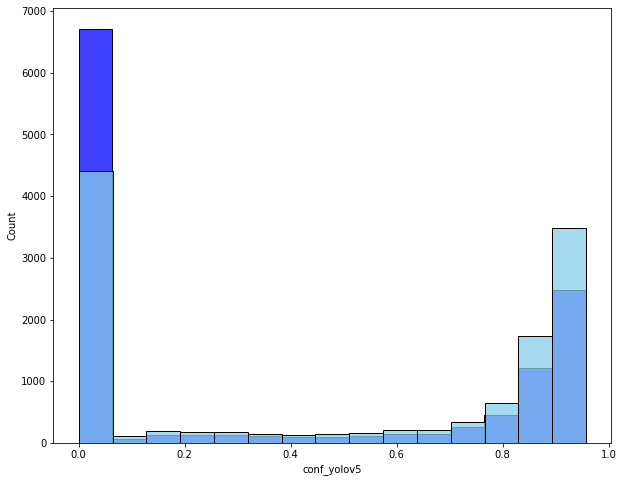

In [28]:
plt.figure(figsize=(10,8))
sns.histplot(data=s1, x="conf_yolov5", color="blue", label="YOLO")
sns.histplot(data=s2, x="conf_yolov5", color="skyblue", label="YOLO")

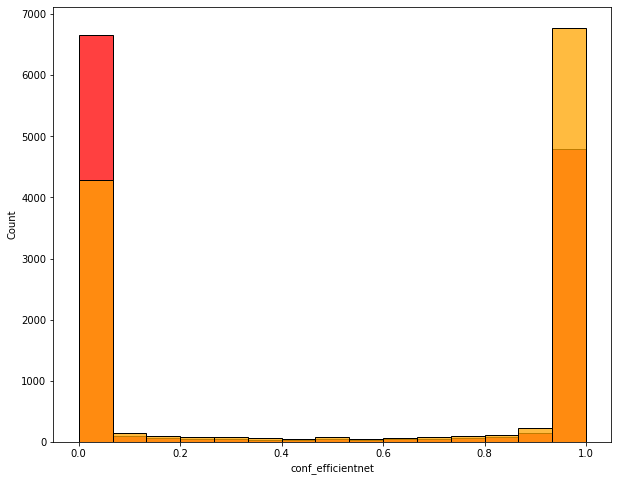

In [29]:
plt.figure(figsize=(10,8))
sns.histplot(data=s1, x="conf_efficientnet", color="red", label="EFFICIENTNET")
sns.histplot(data=s2, x="conf_efficientnet", color="orange", label="EFFICIENTNET")

</center><img src="Sample point.png"  width="1500" height="500"/></center>

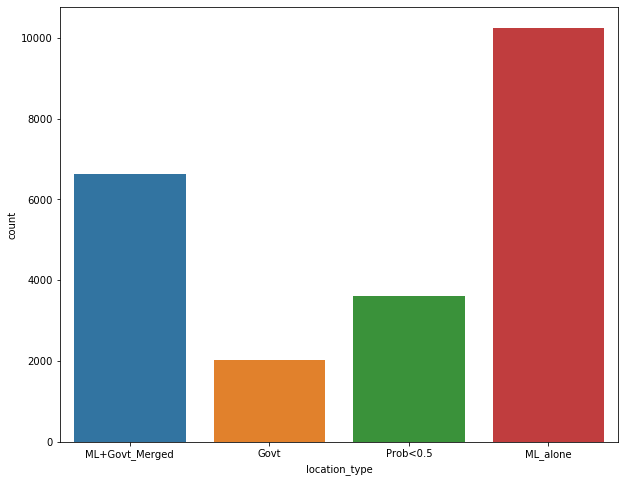

In [9]:
plt.figure(figsize=(10,8))
sns.countplot(x ='location_type', data = s3)

In [11]:
s3['location_type'].value_counts()

ML_alone          10248
ML+Govt_Merged     6632
Prob<0.5           3611
Govt               2037
Name: location_type, dtype: int64

In [10]:
s3.shape

(22528, 186)

In [36]:
merged_data.head()

,Unnamed: 0,year(العام),state_nam,locality_nam,school_nam,MOEcode,location,lat_gov,lon_gov,Type,...,photo_file,Head_Teacher_Name,Head_Teacher_Cellphone_Number,original_index,gt_image_id,conf_efficientnet,conf_yolov5,location_type,lat,lon
0,0.0,2018_2019,Northern,murwi,فرح محمد بك القرانيه,11101301.0,urban,18.538573,31.840170,boys,...,1553166497687.jpg,صلاح سليمان الرفاعي محمد,121165932.0,1.0,1.0,0.000033,0.000000,2.0,18.538836,31.841101
1,1.0,2018_2019,Northern,murwi,مصطفى مبروك بنين,11101302.0,urban,18.544802,31.843675,boys,...,1553160939260.jpg,مبارك الله جابو الحسن,122236404.0,2.0,2.0,0.999996,0.876609,1.0,18.544802,31.843675
2,2.0,2018_2019,Northern,murwi,سر الختم محمد الطيب بنين,11101303.0,rural,18.517909,31.820415,boys,...,1553411047305.jpg,عمر عبد المجيد عطا السيد,111279873.0,3.0,3.0,0.684962,0.154784,2.0,18.517528,31.819590
3,3.0,2018_2019,Northern,murwi,مروي شرق بنين,11101304.0,urban,18.483851,31.800364,boys,...,1553084960867.jpg,نعمات على محجوب عمر,915547693.0,4.0,4.0,0.000099,0.000000,2.0,18.484810,31.801202
4,4.0,2018_2019,Northern,murwi,الشهيد جكنون الاساسيه بنين,11101305.0,urban,18.560670,31.855010,boys,...,1553163196043.jpg,كمال محمد أحمد عباس,112519174.0,5.0,5.0,0.528040,0.885101,1.0,18.560670,31.855010


In [57]:
merged_data.head()

,Unnamed: 0,year(العام),state_nam,locality_nam,school_nam,MOEcode,location,lat_gov,lon_gov,Type,...,original_index,gt_image_id,conf_efficientnet,conf_yolov5,location_type,lat,lon,giga_id_school,giga_school_id_seq,country_code
0,0.0,2018_2019,Northern,murwi,فرح محمد بك القرانيه,11101301.0,urban,18.538573,31.840170,boys,...,1.0,1.0,0.000033,0.000000,2.0,18.538836,31.841101,d5afe2a9-4263-33c2-9586-f8a6fd44258d,ML_SD_000001,SD
1,1.0,2018_2019,Northern,murwi,مصطفى مبروك بنين,11101302.0,urban,18.544802,31.843675,boys,...,2.0,2.0,0.999996,0.876609,1.0,18.544802,31.843675,e434f781-7644-385b-bc38-2a84ab34a17c,ML_SD_000002,SD
2,2.0,2018_2019,Northern,murwi,سر الختم محمد الطيب بنين,11101303.0,rural,18.517909,31.820415,boys,...,3.0,3.0,0.684962,0.154784,2.0,18.517528,31.819590,a2ca1df0-6960-395a-b0c5-665232616244,ML_SD_000003,SD
3,3.0,2018_2019,Northern,murwi,مروي شرق بنين,11101304.0,urban,18.483851,31.800364,boys,...,4.0,4.0,0.000099,0.000000,2.0,18.484810,31.801202,df2cedc4-a637-3feb-b3b3-be509e1c6292,ML_SD_000004,SD
4,4.0,2018_2019,Northern,murwi,الشهيد جكنون الاساسيه بنين,11101305.0,urban,18.560670,31.855010,boys,...,5.0,5.0,0.528040,0.885101,1.0,18.560670,31.855010,b0a5eddf-b8de-322d-bf49-5c5f87a6e1d7,ML_SD_000005,SD


In [48]:
print(merged_data.columns)

Index(['Unnamed: 0', 'year(العام)', 'state_nam', 'locality_nam', 'school_nam',
       'MOEcode', 'location', 'lat_gov', 'lon_gov', 'Type',
       ...
       'original_index', 'gt_image_id', 'conf_efficientnet', 'conf_yolov5',
       'location_type', 'lat', 'lon', 'giga_id_school', 'giga_school_id_seq',
       'country_code'],
      dtype='object', length=190)
